In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import keras
import keras_nlp

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

from datetime import datetime
import utils


In [25]:
keras.utils.set_random_seed(69)

In [26]:
df = pd.read_csv("../data/clean/dataset_final.csv")
df.head()

,Task,Category
0,delegate task to team,urgent not-important
1,organize the file for the company-wide audit,urgent important
2,plan time for extracurricular activity,not-urgent important
3,update website content,not-urgent important
4,buy supply for upcoming school project,not-urgent important


# Create Dataset

In [27]:
sentences = df["Task"].to_numpy()
labels = df["Category"].to_numpy()

dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))
dataset = dataset.shuffle(len(dataset))

print(sentences[:10])
print()
print(labels[:10])

['delegate task to team' 'organize the file for the company-wide audit'
 'plan time for extracurricular activity' 'update website content'
 'buy supply for upcoming school project' 'be patient with yourself'
 'update student profile' 'organize course syllabus'
 'practice public speaking' 'confirm lunch location and time']

['urgent not-important' 'urgent important' 'not-urgent important'
 'not-urgent important' 'not-urgent important' 'not-urgent important'
 'urgent not-important' 'not-urgent not-important' 'not-urgent important'
 'urgent not-important']


# Hyperparameters

In [28]:
EMBEDDING_DIM = 64
MAX_LENGTH = 74
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128

# Split Dataset

In [29]:
train_size = int(len(dataset) * TRAINING_SPLIT)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

train_ds = train_ds.batch(NUM_BATCHES)
val_ds = val_ds.batch(NUM_BATCHES)

print(f"There are {len(train_ds)} batches for a total of {NUM_BATCHES*len(train_ds)} elements for training.")
print(f"There are {len(val_ds)} batches for a total of {NUM_BATCHES*len(val_ds)} elements for validation.")

There are 22 batches for a total of 2816 elements for training.
There are 3 batches for a total of 384 elements for validation.


# Vectorize Dataset

In [30]:
train_sentences = train_ds.map(lambda x, _: x)  
train_labels = train_ds.map(lambda _, y: y)

In [31]:
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_sentences,
    lowercase=True,
    vocabulary_size=8000,
    reserved_tokens=["[PAD]", "[UNK]"],
)

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=True,
    sequence_length=MAX_LENGTH
)

vocab_size = tokenizer.vocabulary_size()
print(f"Vocabulary size = {vocab_size}")

Vocabulary size = 526


In [32]:
label_lookup = keras.layers.StringLookup(num_oov_indices=0)
label_lookup.adapt(train_labels)

print(f"Label size = {label_lookup.vocabulary_size()}")

Label size = 4


In [33]:
for x, y in val_ds.take(1):
    sample_string = x[1]

tokenized_string = tokenizer.tokenize(sample_string)
print(f"Tokenized string is {tokenized_string}")

original_string = tokenizer.detokenize(tokenized_string)
print(f"The original string: {original_string}")

Tokenized string is [ 69 312 103   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
The original string: b'create revision note [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'


In [34]:
train_ds_vec = train_ds.map(lambda x, y: (tokenizer(x), label_lookup(y)))
val_ds_vec = val_ds.map(lambda x, y: (tokenizer(x), label_lookup(y)))

for features, labels in train_ds_vec.take(1):
    print("Features:", features.numpy())
    print("Labels:", labels.numpy())

Features: [[ 50 336  45 ...   0   0   0]
 [177  45  35 ...   0   0   0]
 [138 265 310 ...   0   0   0]
 ...
 [ 63  44  65 ...   0   0   0]
 [ 63  44 332 ...   0   0   0]
 [130 143 440 ...   0   0   0]]
Labels: [3 3 2 0 3 0 3 3 2 0 1 3 3 3 3 3 2 1 2 3 1 3 0 2 0 2 0 3 3 2 1 0 2 2 2 1 1
 2 2 3 0 0 0 2 2 1 3 2 1 2 2 1 1 1 3 1 1 3 1 0 2 1 1 2 3 3 0 1 1 0 0 2 1 0
 2 3 3 3 1 1 3 1 1 0 3 3 2 2 3 2 2 3 3 2 2 1 0 1 2 3 3 2 2 1 0 3 1 3 1 1 2
 0 0 1 1 1 3 3 1 2 1 0 0 2 0 1 1 0]


# Train

In [49]:
model = keras.Sequential([
    keras.Input(shape=(MAX_LENGTH,)),
    keras.layers.Embedding(vocab_size, EMBEDDING_DIM),
    keras.layers.Bidirectional(keras.layers.LSTM(128)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, "relu"),
    keras.layers.Dense(4, "softmax"),
])

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 74, 64)            33664     
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              197632    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 32)                8224      
                                                                 
 dense_15 (Dense)            (None, 4)                 132       
                                                                 
Total params: 239,652
Trainable params: 239,652
Non-trainable params: 0
________________________________________________

In [50]:
history = model.fit(train_ds_vec, epochs=100, validation_data=val_ds_vec)

Epoch 1/100
22/22 [==============================] - 4s 75ms/step - loss: 1.3752 - accuracy: 0.3434 - val_loss: 1.3374 - val_accuracy: 0.5083
Epoch 2/100
22/22 [==============================] - 1s 45ms/step - loss: 1.2525 - accuracy: 0.4518 - val_loss: 1.0850 - val_accuracy: 0.5710
Epoch 3/100
22/22 [==============================] - 1s 44ms/step - loss: 0.9778 - accuracy: 0.6011 - val_loss: 0.8184 - val_accuracy: 0.6898
Epoch 4/100
22/22 [==============================] - 1s 44ms/step - loss: 0.7713 - accuracy: 0.6938 - val_loss: 0.6860 - val_accuracy: 0.7327
Epoch 5/100
22/22 [==============================] - 1s 48ms/step - loss: 0.6511 - accuracy: 0.7456 - val_loss: 0.5259 - val_accuracy: 0.8020
Epoch 6/100
22/22 [==============================] - 1s 44ms/step - loss: 0.5783 - accuracy: 0.7768 - val_loss: 0.5417 - val_accuracy: 0.7756
Epoch 7/100
22/22 [==============================] - 1s 43ms/step - loss: 0.5357 - accuracy: 0.7949 - val_loss: 0.5176 - val_accuracy: 0.8020
Epoch 

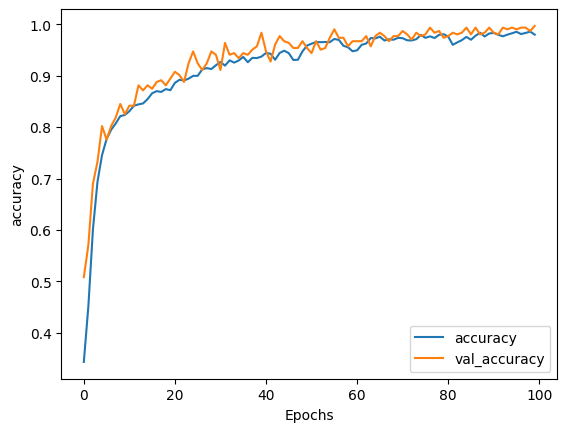

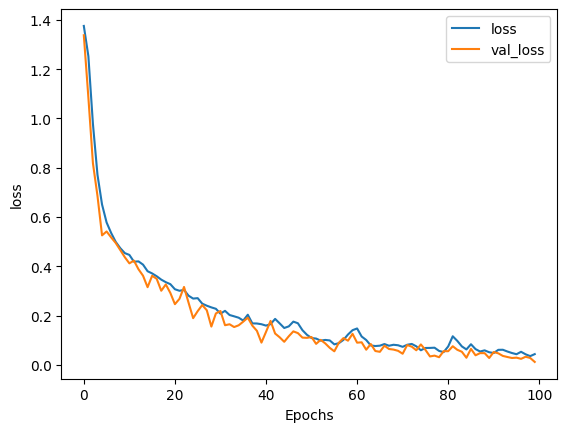

In [51]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Test

In [58]:
task = "finish the assignment that's due tonight"
print(f"Input: {task}")

task = utils.lemmatize(task)
print(f"Lemmatized input: {task}")

task_vec = tokenizer(task)
print(f"Vectorized input: {tokenizer.detokenize(task_vec)}")
print(f"\t{[x for x in task_vec.numpy()]}\n")
task_vec = np.reshape(task_vec, (1, len(task_vec)))

prediction = model.predict(task_vec)[0]
print(f"Prediction vector: {prediction}")

label_vocab = label_lookup.get_vocabulary()
for label, probability in zip(label_vocab, prediction):
    percentage = probability * 100
    print(f"\t{label}: {percentage:.5f}%")

best = label_vocab[np.argmax(prediction)]
print(f"Prediction: {best}")

Input: finish the assignment that's due tonight
Lemmatized input: finish the assignment that's due tonight
Vectorized input: b"finish the assignment that ' s due tonight [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"
	[365, 44, 121, 35, 220, 194, 3, 34, 302, 230, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1/1 [==============================] - 0s 29ms/step
Prediction vector: [3.1532707e-11 9.9999678e-01 7.9908517e-11 3.2099410e-06]
	not-urgent important: 0.00000%
	urgent important: 99.99968%
	not-urgent not

# Save

In [ ]:
packed_model = keras.Sequential([
    tokenizer,
    label_lookup,
    model,
])

packed_model.built = True
now = datetime.now().strftime(r"%Y-%m-%d_%H-%M-%S")
packed_model.save(f"../model/{now}.keras")

NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer StringLookup with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x0000023DEE3F6050>]